Upload both the quantized and unquantized tflite model files.

In [7]:
!pip3 install --upgrade -i https://test.pypi.org/simple/ MLEXray


Looking in indexes: https://test.pypi.org/simple/
     |████████████████████████████████| 48 kB 4.9 MB/s 
  Attempting uninstall: MLEXray
    Found existing installation: MLEXray 0.0.8
    Uninstalling MLEXray-0.0.8:
      Successfully uninstalled MLEXray-0.0.8


Define a model runner class

In [2]:
import os
import tensorflow as tf
import numpy as np
from tqdm import tqdm

from MLEXray.EdgeMLMonitor.EdgeMLMonitor import EdgeMLMonitor
from MLEXray.Utils.tf_utils import KerasModel_preprocessing

class Tflite_Image_Classification_Model_Runner():
    interpreter = None
    input_details = None
    output_details = None
    input_size = None
    quantized = None

    def __init__(self,
                 model_name,
                 quantized,
                 tflite_model_dir=None,
                 tflite_model=None,
                 per_layer_logging=False,
                 referenceOp=False
                 ):
        if tflite_model is None and tflite_model_dir is None:
            raise ValueError(f"Either model content or model path has to be provided")
        OpResolver = tf.lite.experimental.OpResolverType.AUTO
        if referenceOp:
            OpResolver = tf.lite.experimental.OpResolverType.BUILTIN_REF
        self.interpreter = tf.lite.Interpreter(model_content=tflite_model,
                                               model_path=tflite_model_dir,
                                               experimental_preserve_all_tensors=True,
                                               experimental_op_resolver_type=OpResolver)
        self.interpreter.allocate_tensors()
        self.input_details = self.interpreter.get_input_details()[0] # assume only 1 input, image
        self.output_details = self.interpreter.get_output_details()[0] # assume only 1 output, predictions
        self.input_size = self.input_details['shape'][-2]
        self.quantized = quantized

        self.model_name = model_name
        self.mMonitor = EdgeMLMonitor()

        if per_layer_logging:
            self.mMonitor.set_per_layer_output_logging(True)
        else:
            self.mMonitor.set_per_layer_output_logging(False)


    def invoke_model(self, input):
        if self.quantized:
            # Manually quantize the input from float to integer
            scale, zero_point = self.input_details['quantization']
            # print(f"Input details: scale:{scale}, zero_point:{zero_point}")
            tflite_integer_input = input / scale + zero_point
            tflite_integer_input = tf.cast(tflite_integer_input, self.input_details['dtype'])
            # print(tflite_integer_input.shape)
            tf_input = tflite_integer_input
        else:
            tf_input = input

        self.interpreter.set_tensor(self.input_details['index'], tf_input)
        self.interpreter.invoke()
        tflite_output = self.interpreter.get_tensor(self.output_details['index'])
        if self.quantized:
            # Manually dequantize the output from integer to float
            scale, zero_point = self.output_details['quantization']
            # print(f"Output details: scale:{scale}, zero_point:{zero_point}")
            tf_output = tflite_output.astype(np.float32)
            tf_output = (tf_output - zero_point) * scale
        else:
            tf_output = tflite_output

        result = dict()
        result['input'] = tf_input.numpy()
        result['predictions'] = tf_output

        return result

    def run_image_data_folder(self, data_path, logDir, enableLog=True):
        """

        :param data_path:
        :param logDir:
        :param enableLog: default as True, set False to skip logging for performance eval
        :return:
        """
        print(f"Running model on dataset: {data_path}")

        if enableLog: self.mMonitor.set_logDir(logDir)
        images = os.listdir(data_path)
        images = sorted(images)
        idx = 0
        # while idx < len(images):
        result = []
        imgmetas = []
        for i in tqdm(range(len(images))):
            image = images[i]
            if 'png' not in image.lower() and 'jpg' not in image.lower() and 'jpeg' not in image.lower():
                continue
            res, imgmeta = self.run_one_image(data_path + image, enableLog)
            idx += 1
            result.append(res)
            imgmetas.append(imgmeta)
        return images, imgmetas, result

    def run_one_image(self, image_path, enableLog=False):
        if ".jpg" in image_path.lower() or ".jpeg" in image_path.lower():
            raw_tf_image = tf.image.decode_jpeg(tf.io.read_file(image_path))
        elif ".png" in image_path.lower():
            raw_tf_image = tf.image.decode_png(tf.io.read_file(image_path))
        else:
            raise ValueError(f"{image_path} type not supported")

        raw_tf_image = np.array(raw_tf_image)
        # add channel permutation bug
        # raw_tf_image = cv2.cvtColor(raw_tf_image, cv2.COLOR_BGR2RGB)

        raw_image = tf.expand_dims(raw_tf_image, axis=0)
        image = tf.cast(raw_image, tf.float32)

        image = tf.image.resize(image, [self.input_size, self.input_size], method=tf.image.ResizeMethod.AREA)
        # image = tf.image.resize(image, [self.input_size, self.input_size], method=tf.image.ResizeMethod.BILINEAR)
        image = KerasModel_preprocessing(image, model_name=self.model_name)
        # print(image)
        if enableLog: self.mMonitor.onInferenceStart()
        result = self.invoke_model(image)
        if enableLog: self.mMonitor.onInferenceStop(self.interpreter, result, raw_input=raw_image)
        img_meta = dict()
        img_meta["size"] = raw_tf_image.shape
        return result, img_meta

Run the model on one image and get the logs

In [3]:
model_name = "MobileNetV2" # must be exactly MobileNetV2 to use preprocessing functions from internal library
per_layer_logging = True
referenceOp = True
data_path = "/content/Image/"
# run unquant model
tflite_path_unquant = "/content/MobileNetV2_imagenet_224.tflite" # make sure to upload to the tflite here
log_path_unquant = "/content/1_cloud_tflite/"
runner = Tflite_Image_Classification_Model_Runner(model_name=model_name,
                                                  quantized=False,
                                                  tflite_model_dir=tflite_path_unquant,
                                                  per_layer_logging=per_layer_logging,
                                                  referenceOp=referenceOp)
imgs, meta, res = runner.run_image_data_folder(data_path, log_path_unquant, enableLog=True)

# run quant model
tflite_path_quant = "/content/MobileNetV2_imagenet_quant_224.tflite" # make sure to upload to the tflite here   
log_path_quant = "/content/1_cloud_tflite_quant/"
runner = Tflite_Image_Classification_Model_Runner(model_name=model_name,
                                                  quantized=True,
                                                  tflite_model_dir=tflite_path_quant,
                                                  per_layer_logging=per_layer_logging,
                                                  referenceOp=referenceOp)
imgs, meta, res = runner.run_image_data_folder(data_path, log_path_quant, enableLog=True)

Running model on dataset: /content/Image/


100%|██████████| 2/2 [02:05<00:00, 62.86s/it]


Running model on dataset: /content/Image/


100%|██████████| 2/2 [00:38<00:00, 19.12s/it]


Compare per-layer output of the two logs

In [4]:
from MLEXray.ML_Diff.MLLogReader import MLLogReader
from MLEXray.ML_Diff.MLDiffer import MLDiffer

output_dir = "/content/quantRef_vs_unquantRef/"


mReader = MLLogReader(per_layer_output=True, model_path=tflite_path_quant)

pd_tflite_quant = mReader.read_log(log_path_quant)
pd_tflite_unquant = mReader.read_log(log_path_unquant)

print(pd_tflite_quant)
print(pd_tflite_unquant)

name_list = ["Quant_RefOp", "Unquant_RefOp"]
trace_list = [pd_tflite_quant, pd_tflite_unquant]

tflite_model_list = [tflite_path_quant, tflite_path_unquant]

mDiffer = MLDiffer()
mDiffer.diff(trace_list, name_list, scalar_key_list=None,
             vector_key_list=mReader.vector_key_list, tflite_model_list=tflite_model_list, output_dir=output_dir, per_layer_fig=False)

                                             input_1  ...                                           Identity
0  [175.0, 186.0, 187.0, 178.0, 189.0, 190.0, 180...  ...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

[1 rows x 180 columns]
                                             input_1  ...                                           Identity
0  [0.370461106300354, 0.4598938226699829, 0.4692...  ...  [5.81094209337607e-05, 8.608310599811375e-05, ...

[1 rows x 178 columns]


Plot normalized per-layer root-mean-square-error

114     6.000000
115    35.566396
116     6.000000
117     6.000000
118    55.683355
         ...    
172     6.000000
173    18.461038
174     6.000000
175     4.808304
176    12.398122
Length: 63, dtype: float64


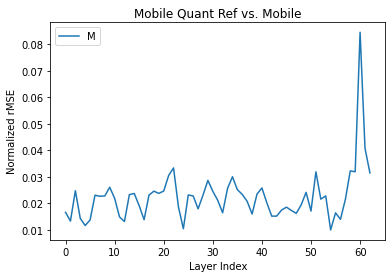

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from MLEXray.plots.per_layer_plots import get_norm_rmse_from_csv

per_layer_compare_file = "/content/quantRef_vs_unquantRef/0_0_debug_report.csv"
output_start_layer_index = 114 # the starting index of layer output tensor in tflite, can inspect from netron.app
pd_data = get_norm_rmse_from_csv(fp=per_layer_compare_file,
                                  output_row_start=output_start_layer_index)

plt.figure()
# print(pd_data)
sns.lineplot(data=pd_data, markers=True)
plt.xlabel("Layer Index")
plt.ylabel("Normalized rMSE")
plt.legend("MobileNetv3 Small")
plt.title("Mobile Quant Ref vs. Mobile")
plt.show()
